In [31]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [55]:
# actual data
data_fetch_dates = ['0905', '0706', '0207']
actual_data = pd.concat([pd.merge(
    pd.read_csv(f'actualdata_trips_{date}.csv'), pd.read_csv(f'actualdata_stop_times_{date}.csv'), 
    how='left', left_on=['TripId'], right_on='TripId'
) for date in data_fetch_dates], axis=0)
actual_data['Month'] = [int(str(y)[4:6]) for y in actual_data['StartDate']]

# data cleaning: remove redundant column EntityId because it holds sim(EntityId, TripId) = 1
actual_data.drop('EntityId', axis=1, inplace=True)

actual_data.set_index(['TripId', 'StartDate'], inplace=True)
actual_data.head()

,,RouteId,StartTime,StopId,StopSequence,ArrivalDelay,ArrivalTime,DepartureDelay,DepartureTime,ScheduleRelationship,Month
TripId,StartDate,,,,,,,,,,
254163638,20230508,43975,19:44:00,9057862,NaN,NaN,NaN,0.0,NaN,Scheduled,5
282351984,20230509,43245,17:12:00,9013478,NaN,NaN,NaN,0.0,NaN,Scheduled,5
282385362,20230508,43195,20:03:00,9058008,5.0,-60.0,NaN,0.0,NaN,Scheduled,5
264505093,20230508,59935,19:12:00,9050640,11.0,30.0,NaN,30.0,NaN,Scheduled,5
282384857,20230509,43216,04:37:00,9049320,NaN,NaN,NaN,0.0,NaN,Scheduled,5


In [3]:
# target data
dir_target = 'C:\\Users\\nstan\\OneDrive\\Winfo\\SoSe_23\\Data Integration\\target_data_vbn_modified'
rnames = ['trips', 'stops', 'stop_times', 'agency', 'routes', 'transfers']
target_data = {rname: pd.read_csv(f'{dir_target}\\{rname}.csv', low_memory=False) for rname in rnames}

In [4]:
# perform joins on target data relations
# step 1: join routes and agency (= r1)
r1 = pd.merge(target_data['routes'], target_data['agency'], how='left', left_on=['agency_id'], right_on=['agency_id'])
r1.head(3)

,route_id,agency_id,route_short_name,route_type,agency_name
0,71026,1060,SEV24,1,S-Bahn Hamburg
1,71025,1060,SEV10,1,S-Bahn Hamburg
2,70978,1060,SEV21,2,S-Bahn Hamburg


In [5]:
# step 2: join r1 and trips (= r2)
r2 = pd.merge(r1, target_data['trips'], how='left', left_on=['route_id'], right_on=['route_id'])
r2.head(3)

,route_id,agency_id,route_short_name,route_type,agency_name,service_id,trip_id,trip_headsign,trip_short_name,direction_id
0,71026,1060,SEV24,1,S-Bahn Hamburg,1,282300445,Buxtehude,01000,0
1,71025,1060,SEV10,1,S-Bahn Hamburg,2,282299554,Hamburg-Harburg Rathaus,00001,0
2,71025,1060,SEV10,1,S-Bahn Hamburg,1,282299537,Hamburg-Harburg Rathaus,00001,0


In [6]:
# step 3: join r2 and stop_times (= r3)
r3 = pd.merge(r2, target_data['stop_times'], how='left', left_on=['trip_id'], right_on=['trip_id'])
r3.head(3)

,route_id,agency_id,route_short_name,route_type,agency_name,service_id,trip_id,trip_headsign,trip_short_name,direction_id,arrival_time,departure_time,stop_id,stop_sequence,pickup_type,drop_off_type
0,71026,1060,SEV24,1,S-Bahn Hamburg,1,282300445,Buxtehude,01000,0,23:20:00,23:20:00,8002557,0,0,0
1,71026,1060,SEV24,1,S-Bahn Hamburg,1,282300445,Buxtehude,01000,0,23:25:00,23:25:00,2804001,1,0,0
2,71026,1060,SEV24,1,S-Bahn Hamburg,1,282300445,Buxtehude,01000,0,23:30:00,23:30:00,2047308,2,0,0


In [7]:
# step 3: join r3 and stops (= r4)
r4 = pd.merge(r3, target_data['stops'], how='left', left_on=['stop_id'], right_on=['stop_id'])
r4.head(3)

,route_id,agency_id,route_short_name,route_type,agency_name,service_id,trip_id,trip_headsign,trip_short_name,direction_id,arrival_time,departure_time,stop_id,stop_sequence,pickup_type,drop_off_type,stop_name,stop_lat,stop_lon
0,71026,1060,SEV24,1,S-Bahn Hamburg,1,282300445,Buxtehude,01000,0,23:20:00,23:20:00,8002557,0,0,0,Hamburg-Neugraben,53.474143,9.852048
1,71026,1060,SEV24,1,S-Bahn Hamburg,1,282300445,Buxtehude,01000,0,23:25:00,23:25:00,2804001,1,0,0,Hamburg-Fischbek An de Geest,53.469749,9.818922
2,71026,1060,SEV24,1,S-Bahn Hamburg,1,282300445,Buxtehude,01000,0,23:30:00,23:30:00,2047308,2,0,0,Neu Wulmstorf(Niederelbe) Hauptstraße,53.463750,9.798360


In [8]:
actual_data.info()

<class 'pandas.core.frame.DataFrame'>
MultiIndex: 11273 entries, (254163638, 20230508) to (292610307, 20230702)
Data columns (total 9 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   RouteId               11273 non-null  int64  
 1   StartTime             11273 non-null  object 
 2   StopId                11273 non-null  int64  
 3   StopSequence          3430 non-null   float64
 4   ArrivalDelay          3093 non-null   float64
 5   ArrivalTime           67 non-null     float64
 6   DepartureDelay        11205 non-null  float64
 7   DepartureTime         111 non-null    float64
 8   ScheduleRelationship  11273 non-null  object 
dtypes: float64(5), int64(2), object(2)
memory usage: 1.1+ MB


In [9]:
len(np.unique(actual_data['RouteId']))

1031

In [40]:
# overall delay
arrival_delays = [x for x in actual_data['ArrivalDelay'] if not (pd.isna(x) or x == 0)]
departure_delays = [x for x in actual_data['DepartureDelay'] if not (pd.isna(x) or x == 0)]
ad = len(arrival_delays) / actual_data.shape[0] * 100
dd = len(departure_delays) / actual_data.shape[0] * 100
print('arrival delay in {x} % of rides'.format(x=round(ad, 2)))
print('departure delay in {x} % of rides'.format(x=round(dd, 2)))

print('arrival delay: {x}'.format(x=round(np.mean(arrival_delays), 2)))
print('departure delay: {x}'.format(x=round(np.mean(departure_delays), 2)))

arrival delay in 15.6 % of rides
departure delay in 17.99 % of rides
arrival delay: 110.68
departure delay: 134.61


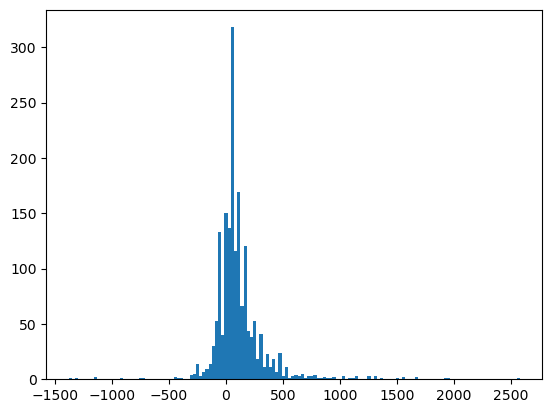

In [39]:
plt.hist(arrival_delays, bins='auto')
plt.show()

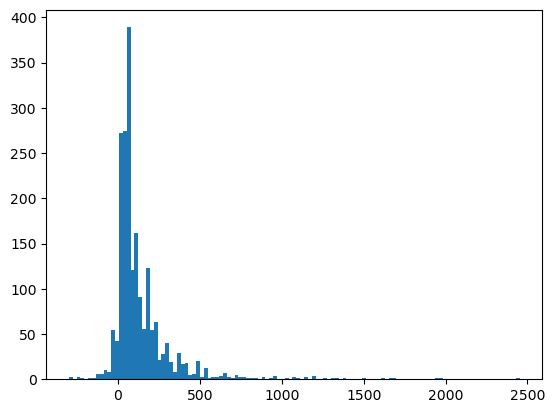

In [38]:
plt.hist(departure_delays, bins='auto')
plt.show()

In [25]:
actual_data[['StopSequence', 'ArrivalDelay', 'DepartureDelay']].groupby('StopSequence').count()

,ArrivalDelay,DepartureDelay
StopSequence,,
1.0,92,115
2.0,128,142
3.0,101,118
4.0,93,107
5.0,89,100
6.0,103,117
7.0,108,120
8.0,115,132
9.0,108,120


In [ ]:
# departure delay > arrival delay => delay increases when trains are in stations

In [ ]:
# step 3: join TARGET trips and stop_times
r4 = pd.merge(target_data['stop_times'], target_data['trips'], how='left', left_on=['trip_id'], right_on=['trip_id'])
r4.head(3)

In [149]:
# join actual and target data using the Route-Id
r = pd.merge(actual_data, r1, how='left', left_on=['RouteId'], right_on=['route_id'])
pd.concat([
    r[['agency_name', 'ArrivalDelay']].where(~pd.isna(r['ArrivalDelay'])).where(
        r['ArrivalDelay'] != 0).groupby(['agency_name']).mean(),
    r[['agency_name', 'DepartureDelay']].where(~pd.isna(r['DepartureDelay'])).where(
        r['DepartureDelay'] != 0).groupby(['agency_name']).mean()
], axis=1).loc[(r['agency_name'].value_counts() > 100).index[r['agency_name'].value_counts() > 200]]

# 1. delay according to different agencies

,ArrivalDelay,DepartureDelay
DB Regio AG Nord,87.789474,164.835165
Bremer Straßenbahn AG,41.569697,38.212838
üstra Hannoversche Verkehrsbetriebe AG,127.000000,107.839572
RegioBus Hannover GmbH,72.971429,139.707143
NordWestBahn,175.531915,417.500000
Braunschweiger Verkehrs-GmbH,89.465116,96.725000
S-Bahn Hannover (Transdev),184.000000,170.000000
Verkehr und Wasser GmbH (VWG),180.069767,171.122222
Verkehrsbetriebe Oldenburger Land,189.391304,210.019231
cantus Verkehrsgesellschaft,20.000000,80.000000


In [ ]:
# join r1 and r4 on Trip Id and Stop Id
# their schemata match for the most part
# however, using a left join enables to get all delays even if there is no join match
# (possible because there is no inclusion dependency)
#r5 = pd.merge(r1, r4, how='inner', left_on=['TripId', 'StopId'], right_on=['trip_id', 'stop_id'])
#r5